In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import admix
from admix.data import zsc2pval, pval2chisq
from utils import load_r2_result, plot_heatmap, plot_heatmap2
from statsmodels.stats.multitest import multipletests
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]
import seaborn as sns

In [2]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [3]:
DATA_DIR = "../compile-data/out/"

In [4]:
df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)
df_covar.index = df_covar.index.astype(str)

# append other covariates
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"
for col in set(covar_map.keys()) | set(df_display["id"]):
    if col in df_covar.columns:
        continue
    else:
        tmp_path = os.path.join(PHENO_DIR, f"{col}.tsv")
        if os.path.exists(tmp_path):
            df_tmp = pd.read_csv(tmp_path, sep="\t", index_col=0).drop(columns=["IID"])
            df_tmp.index = df_tmp.index.astype(str)
            df_covar[col] = df_tmp["PHENO"].reindex(df_covar.index)
        else:
            warnings.warn(f"{tmp_path} does not exist")

with open(os.path.join(DATA_DIR, f"indiv/uk-train.indivlist")) as f:
    train_indiv = [line.strip() for line in f.readlines()]

print(f"# training: {df_covar[df_covar.index.isin(train_indiv)].shape[0]}")
df_test_info = df_covar[~df_covar.index.isin(train_indiv)].copy()
print(f"# testing: {df_test_info.shape[0]}")

# training: 370941
# testing: 117325


In [5]:
df_test_info["group"] = df_test_info["group"].fillna("NaN")

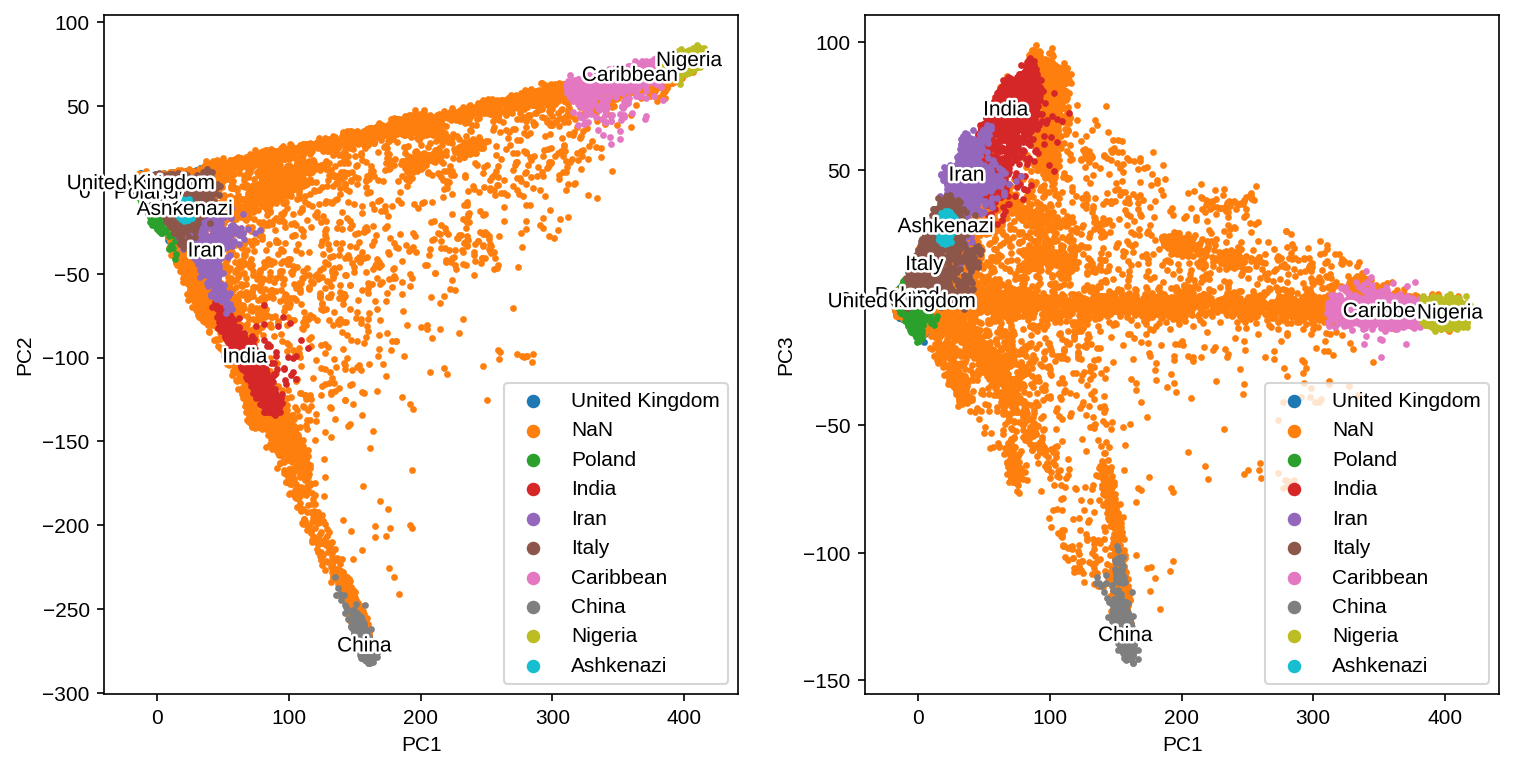

In [6]:
fig, axes = plt.subplots(figsize=(12, 6), dpi=150, ncols=2)
admix.plot.pca(df_test_info, label_col="group", x="PC1", y="PC2", ax=axes[0])
admix.plot.pca(df_test_info, label_col="group", x="PC1", y="PC3", ax=axes[1])
plt.show()

In [7]:
print(f"Testing: # white British: {sum(df_test_info.group == 'United Kingdom')}")
print(f"Testing: # other: {sum(df_test_info.group != 'United Kingdom')}")
print(f"Testing: # all: {len(df_test_info)}")

Testing: # white British: 39993
Testing: # other: 77332
Testing: # all: 117325


# Correlation between covariates

In [8]:
corr1 = (
    df_test_info.loc[df_test_info.group == "United Kingdom", list(covar_map.keys())]
    .corr(method="spearman")
    .rename(index=covar_map, columns=covar_map)
)
corr2 = (
    df_test_info.loc[:, list(covar_map.keys())]
    .corr(method="spearman")
    .rename(index=covar_map, columns=covar_map)
)

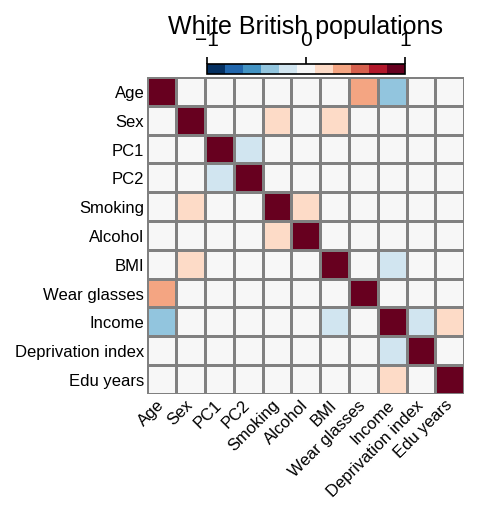

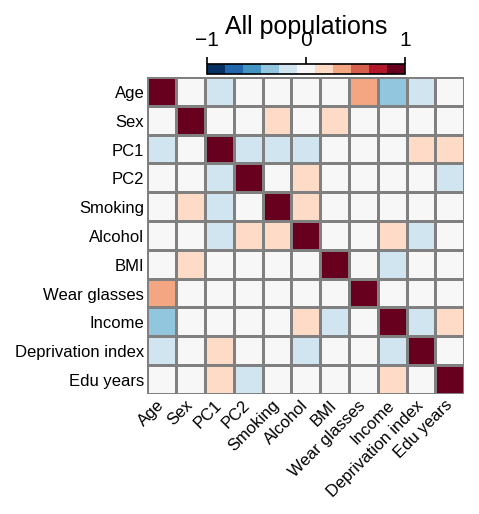

In [9]:
for i, group in enumerate(["white", "all"]):
    corr = corr1 if group == "white" else corr2
    label = "White British populations" if group == "white" else "All populations"
    fig, ax = plot_heatmap(
        corr,
        heatmap_vmin=-1,
        heatmap_vmax=1,
        squaresize=30,
        cmap=plt.get_cmap("RdBu_r", 11),
    )
    fig.suptitle(label, y=1.15)
    cbar = ax.collections[0].colorbar
    cbar.outline.set_edgecolor("black")
    cbar.outline.set_linewidth(0.8)
    plt.savefig(f"results/covar_corr_heatmap.{group}.pdf", bbox_inches="tight")